# Описание проекта

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,  
- выгрузка всех заказов за этот период,  
- статистика рекламных расходов.  

Цели к изучению:
- как клиенты пользуются сервисом,  
- когда делают первые покупки на сайте,   
- сколько денег приносит компании каждый клиент,  
- когда расходы на привлечение клиента окупаются.    

Выручка измеряется в условных единицах — у.е.

<h1> Описание данных</h1>    

`visits_log.csv` - хранит лог сервера с информацией о посещениях сайта.    
Uid — уникальный идентификатор пользователя,     
Device — категория устройства пользователя,    
Start Ts — дата и время начала сессии,   
End Ts — дата и время окончания сессии,    
Source Id — идентификатор источника перехода на сайт.   

`orders_log.csv` - содержит информацию о заказах.    
Uid — уникальный идентификатор пользователя,      
Buy Ts — дата и время заказа,    
Revenue — сумма заказа.   

`costs.csv` - хранит информацию о расходах на маркетинг.    
source_id — идентификатор рекламного источника,    
dt — дата проведения рекламной кампании,     
costs — расходы на эту кампанию.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

# Изучение и предобработка данных

## Импорт данных

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [3]:
visits['Uid'].duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
359395     True
359396     True
359397     True
359398     True
359399     True
Name: Uid, Length: 359400, dtype: bool

## Предобработка log

In [4]:
visits.head(3)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


In [5]:
visits.info()
visits.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


(359400, 5)

Пропуски отсутсвуют. Размер таблицы 359400 на 5.

In [6]:
# найдем дубликаты
dup = visits.duplicated().sum()
if dup == 0:
    print('Дубликаты отсутствуют')
else:
    print(f'Есть дубликаты в кол-ве: {dup}')

Дубликаты отсутствуют


In [7]:
# переведём End Ts и Start Ts в формат datetime
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format = '%Y-%m-%d %H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
# выведем названия столбцов
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [9]:
# переименуем названия столбцов
visits.columns = 'device', 'end_ts', 'source_id', 'start_ts', 'uid'

In [10]:
print(visits['start_ts'].describe())
print(visits['end_ts'].describe())

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object
count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object


<ipython-input-10-b00a77a4476c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(visits['start_ts'].describe())
<ipython-input-10-b00a77a4476c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(visits['end_ts'].describe())


**Вывод:**   
есть сессии, который закончились 2018-06-01. Не будем удалять эти данные иначе можно потерять посещения предыдущего дня.

In [11]:
visits['device'] = visits['device'].astype('category')

In [12]:
print('Пользовтаели посещают платформу Я.Афиши с устройств:',visits['device'].unique())

Пользовтаели посещают платформу Я.Афиши с устройств: ['touch', 'desktop']
Categories (2, object): ['touch', 'desktop']


In [13]:
visits.groupby(['device']).agg({'uid':'count'})

,uid
device,
desktop,262567
touch,96833


**Вывод:**   
с десктопа посещают в 2.7 раза больше, чем с touch устройств

In [14]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


## Предобработка orders

In [15]:
orders.head(3)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [16]:
orders.info()
orders.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


(50415, 3)

Пропуски отсутсвуют. Размер таблицы 50415 на 3.

In [17]:
# найдем дубликаты
dup = orders.duplicated().sum()
if dup == 0:
    print('Дубликаты отсутствуют')
else:
    print(f'есть дубликаты в кол-ве: {dup}')

Дубликаты отсутствуют


In [18]:
# переведём Buy Ts в формат datetime
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format = '%Y-%m-%d %H:%M:%S')

In [19]:
orders.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [20]:
# переименуем названия столбцов
orders.columns = 'buy_ts', 'revenue', 'uid'

In [21]:
print(orders['buy_ts'].describe())

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object


<ipython-input-21-9e7b6a1b2349>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(orders['buy_ts'].describe())


In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


## Предобработка costs

In [23]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [24]:
costs.info()
costs.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


(2542, 3)

Пропуски отсутсвуют. Размер таблицы 2542 на 3.

In [25]:
# найдем дубликаты
dup = costs.duplicated().sum()
if dup == 0:
    print('Дубликаты отсутствуют')
else:
    print(f'есть дубликаты в кол-ве: {dup}')

Дубликаты отсутствуют


In [26]:
# переведём Buy Ts в формат datetime
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

In [27]:
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [28]:
print(costs['dt'].describe())

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object


<ipython-input-28-1f792af83b2c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(costs['dt'].describe())


In [29]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [30]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

# Рассчитаем метрики и построим графики

Метрики для расчёта:
 - продуктовые
 - метрики эл. коммерции.
 - маркетинговые
 ## Продуктовые метрики

In [31]:
visits['date'] = visits['start_ts'].dt.date
visits['day_number'] = visits['start_ts'].dt.day
visits['month_number'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['week_number'] = visits['start_ts'].astype('datetime64[W]')
visits['day_of_week'] = visits['start_ts'].dt.day_name()
visits['month_name'] = visits['start_ts'].astype('datetime64[M]')

visits.head(5)

,device,end_ts,source_id,start_ts,uid,date,day_number,month_number,year,week_number,day_of_week,month_name
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,12,2017,2017-12-14,Wednesday,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,2,2018,2018-02-15,Monday,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,7,2017,2017-06-29,Saturday,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,2018-05-17,Sunday,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,12,2017,2017-12-21,Wednesday,2017-12-01


### DAU, WAU, MAU

In [32]:
dau_total = visits.groupby(['date']).agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['week_number']).agg({'uid':'nunique'}).mean()
mau_total = visits.groupby(['month_number']).agg({'uid':'nunique'}).mean()

print(f'Ежeдневная аудитория DAU: {dau_total[0]:.0f} человек')
print(f'Еженедельная аудитория WAU: {wau_total[0]:.0f} человек')
print(f'Ежемесячная аудитория WAU: {mau_total[0]:.0f} человек')

Ежeдневная аудитория DAU: 908 человек
Еженедельная аудитория WAU: 5724 человек
Ежемесячная аудитория WAU: 23228 человек


In [33]:
sticky_wau = (dau_total/wau_total)
sticky_mau = (dau_total/mau_total)
print(f' Sticky Factor (недельный) {sticky_wau[0]:.2%}')
print(f' Sticky Factor (месячный) {sticky_mau[0]:.2%}')

 Sticky Factor (недельный) 15.86%
 Sticky Factor (месячный) 3.91%


**Вывод:**  
15.59% посетителей обращаются к Я.Афише в течении недели, а 3.91% посетителей обращается к Я.Афише в течении месяца. 

Данному сервису сложно удержать внимание посетителей на таком длинном промежутке времени.  Предполагаю, что данный результат достаточно низкий для подобного сервиса.

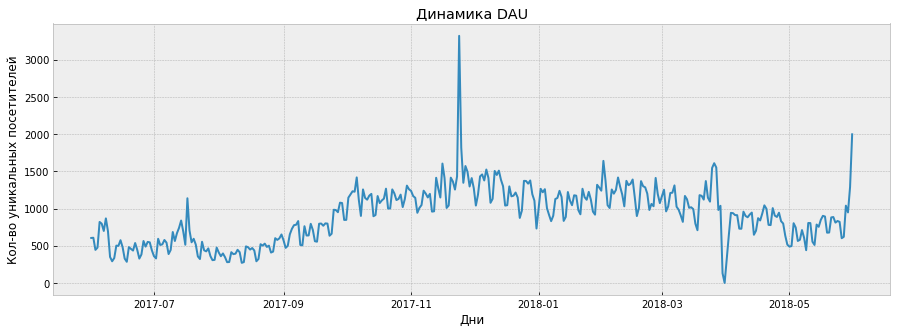

In [34]:
# стиль для графиков
plt.rcParams['figure.figsize']=(15,5)
plt.style.use('bmh')
dau_dynamic = visits.groupby(['date']).agg({'uid':'nunique'}).reset_index()
sns.lineplot(x = 'date' , y = 'uid', data = dau_dynamic)
plt.title('Динамика DAU')
plt.xlabel('Дни')
plt.ylabel('Кол-во уникальных посетителей')
plt.show()
register_matplotlib_converters()

In [35]:
print(f'Ежeдневная аудитория DAU: {dau_total[0]:.0f} человек')

Ежeдневная аудитория DAU: 908 человек


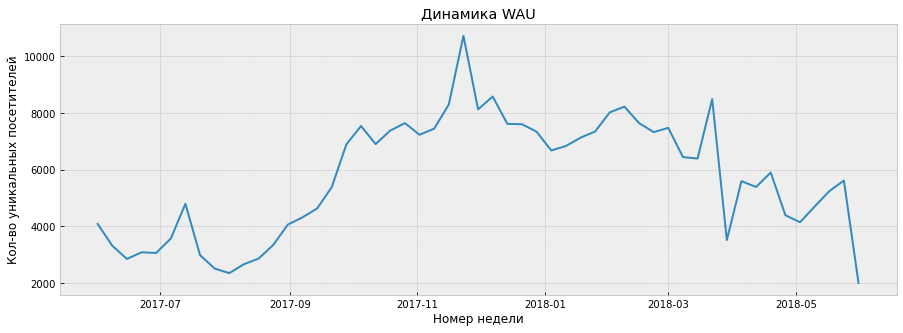

In [36]:
wau_dynamic = visits.groupby(['week_number']).agg({'uid':'nunique'}).reset_index()
sns.lineplot(x = 'week_number' , y = 'uid', data = wau_dynamic)
plt.rcParams['figure.figsize']=(15,5)
plt.title('Динамика WAU')
plt.xlabel('Номер недели')
plt.ylabel('Кол-во уникальных посетителей')
plt.show()

In [37]:
print(f'Ежeдневная аудитория DAU: {wau_total[0]:.0f} человек')

Ежeдневная аудитория DAU: 5724 человек


**Вывод:**   
наблюдаются всплески посещений на: 12, 22 и 47 неделе. Возможно, что это связано с маркетинговыми активностями.

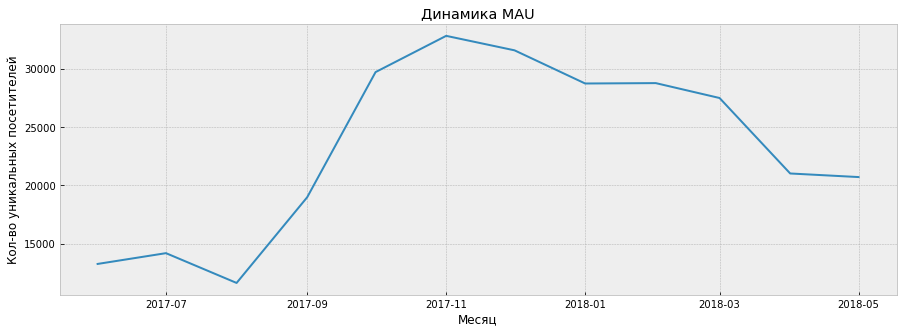

In [38]:
mau_dynamic = visits.groupby(['month_name']).agg({'uid':'nunique'}).reset_index()
sns.lineplot(x = 'month_name' , y = 'uid', data = mau_dynamic)
plt.rcParams['figure.figsize']=(15,5)
plt.title('Динамика MAU')
plt.xlabel('Месяц')
plt.ylabel('Кол-во уникальных посетителей')
plt.show()

In [39]:
print(f'Ежемесячная аудитория WAU: {mau_total[0]:.0f} человек')

Ежемесячная аудитория WAU: 23228 человек


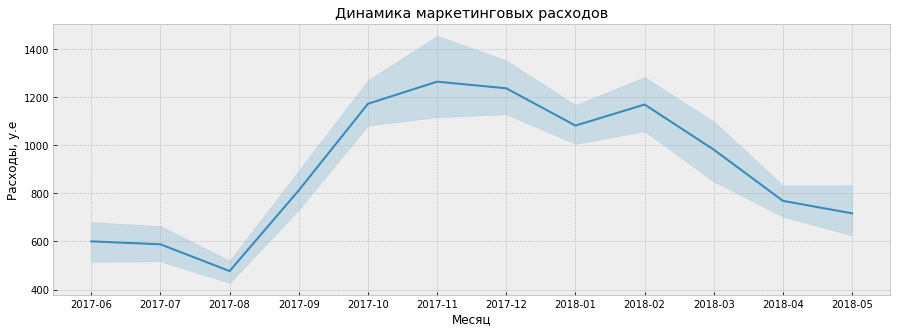

In [40]:
cost_mrkt = costs.groupby(['dt']).agg({'costs':'sum'}).reset_index()
cost_mrkt['dt']=cost_mrkt['dt'].dt.strftime('%Y-%m')
sns.lineplot(x = 'dt' , y = 'costs', data = cost_mrkt)
plt.rcParams['figure.figsize']=(15,5)
plt.title('Динамика маркетинговых расходов')
plt.xlabel('Месяц')
plt.ylabel('Расходы, у.е')
plt.show()

**Вывод:**   
c 09-2017, наблюдаются всплески по маркетинговым активносятм, посещаемость на эту дату также растёт. Соответсвенно посещаемость сильно зависит от маркетинговых активностей. Это видно даже без наложения графиков - <u>WAU</u> и <u>Динамака</u> маркетинговых расходов.        
DAU: 908 человек;    
WAU: 5825 человек;    
WAU: 23228 человек.        


### Сколько сессий в день

In [41]:
session_count = visits.groupby('date').agg({'uid': 'nunique'}).mean()
print(f'Среднее количество сессий в день за период с июня 2017 по конец мая 2018 г.: {session_count[0]:.2f}')

Среднее количество сессий в день за период с июня 2017 по конец мая 2018 г.: 907.99


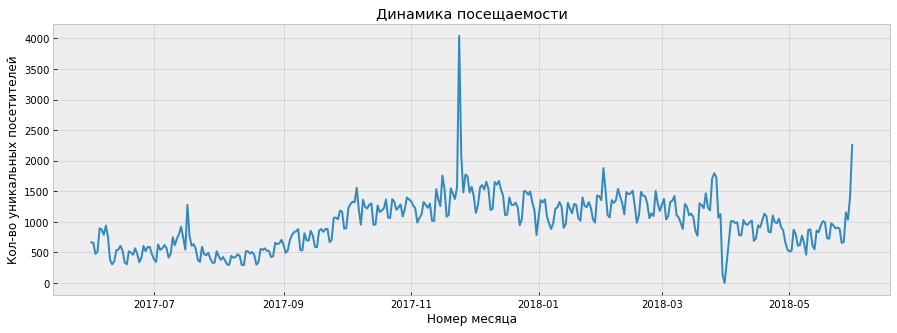

In [42]:
session_month = visits.groupby('date').agg({'uid': 'count'}).reset_index()
sns.lineplot(x='date', y='uid', data = session_month)
plt.title('Динамика посещаемости')
plt.xlabel('Номер месяца')
plt.ylabel('Кол-во уникальных посетителей')
plt.show()

### Сколько длится одна сессия?¶

In [43]:
visits['session_duration_minutes'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()/60
visits['session_duration_minutes'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minutes, dtype: float64

In [44]:
# убираем отрицательные сессии
visits = visits.query('session_duration_minutes >=0')

In [45]:
print(visits['session_duration_minutes'].describe())
print('mode',visits['session_duration_minutes'].mode())

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minutes, dtype: float64
mode 0    1.0
dtype: float64


**Вывод:**   
    продолжительность одной сессии:   
        - в среднем 10 мин.    
        - медиана 5 мин.    
        - мода 1 мин.    
Так как среднее больше медианы, имеем гистограмму смещенную вправо, что вполне естественно для большинства сайтов. А также означает, что больше всего данных лежит примерно до 10 минут.

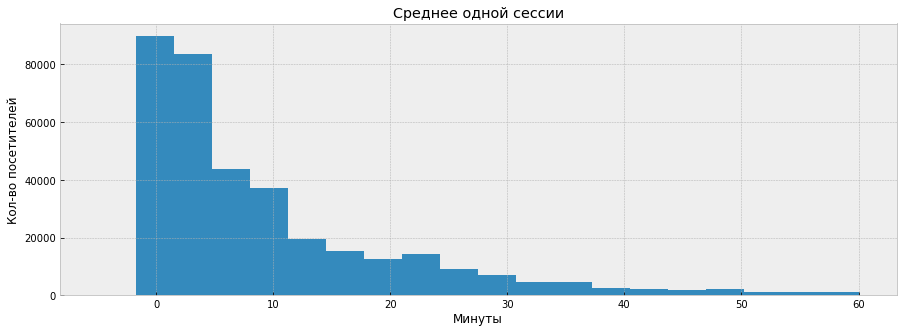

In [46]:
visits['session_duration_minutes'].hist(bins=20, range=(-5, 60))
plt.title('Среднее одной сессии')
plt.xlabel('Минуты')
plt.ylabel('Кол-во посетителей')
plt.show()

**Вывод:**  
ожидания подтвердились гистограммой, следовательно основная часть пользователей проводит до 10 минут на сайте Я.Афиши. Возможно этого достаточно для совершения целевого действия на платформе.

### Retention Rate

In [47]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = 'uid', 'first_visit'
first_visit.head(3)

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00


In [48]:
visits = visits.merge(first_visit)
visits.head(2)

,device,end_ts,source_id,start_ts,uid,date,day_number,month_number,year,week_number,day_of_week,month_name,session_duration_minutes,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,12,2017,2017-12-14,Wednesday,2017-12-01,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,2,2018,2018-02-15,Monday,2018-02-01,28.0,2018-02-19 16:53:00


In [49]:
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head(2)

,device,end_ts,source_id,start_ts,uid,date,day_number,month_number,year,week_number,day_of_week,month_name,session_duration_minutes,first_visit,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,12,2017,2017-12-14,Wednesday,2017-12-01,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,2,2018,2018-02-15,Monday,2018-02-01,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01


In [50]:
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [51]:
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
f_uid = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
f_uid.columns = ['first_visit_month', 'f_uid']
f_uid.head(3)

,first_visit_month,f_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181


In [52]:
cohort_visits = cohort_visits.merge(f_uid)
cohort_visits["retention"] = cohort_visits["uid"] / cohort_visits["f_uid"]
visits_retention_pivot = cohort_visits.pivot_table(
    index="first_visit_month", columns="lifetime", values="retention", aggfunc="sum"
)
visits_retention_pivot.mean() * 100

visits_retention_pivot.index = visits_retention_pivot.index.strftime("%m/%Y")
visits_retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
06/2017,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
07/2017,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
08/2017,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
09/2017,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
10/2017,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
11/2017,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
12/2017,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
01/2018,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2018,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


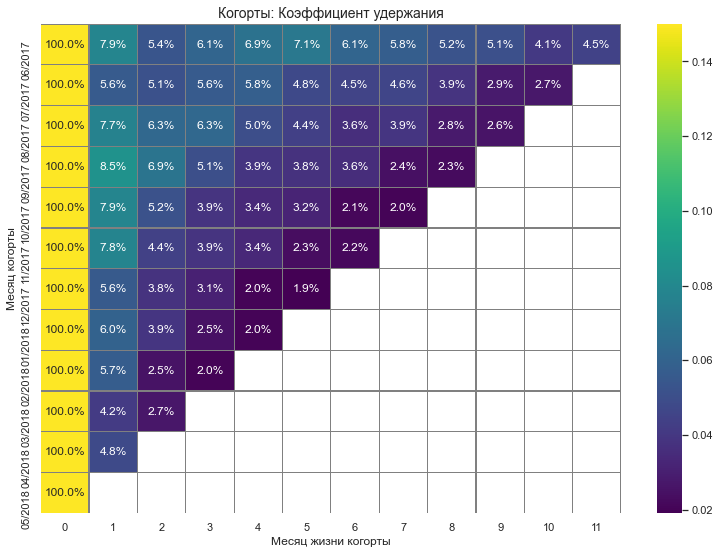

In [53]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: Коэффициент удержания', size=14)
ax =sns.heatmap(visits_retention_pivot, annot=True, fmt='.1%', linewidths=0.2, linecolor='gray', cmap = 'viridis',vmax=0.15)
ax.set_ylabel('Месяц когорты')
ax.set_xlabel('Месяц жизни когорты')
plt.show()

**Вывод:**  
90-95% пользователей отваливается, видимо связано с их особенностью. Мало кто возвращается ежемесячно для покупки билетов или просмотра афиш. Всего скорее сервис используется для посещения знаковых событий, таких как кинопремьеры и выставки.

## Метрики e-commerce
### Время совершения первой покупки

In [54]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_visit_date'})\
                .reset_index()

first_order = orders.groupby('uid').agg({'buy_ts':'min'})\
                .rename(columns={'buy_ts':'first_purchase_date'})\
                .reset_index()

buying_time = first_visit.merge(first_order, on='uid', how='inner')
buying_time.head(3)

,uid,first_visit_date,first_purchase_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00


In [55]:
buying_time['buying_time'] = (buying_time['first_purchase_date'] - buying_time['first_visit_date']).dt.seconds / 60
buying_time.head()

,uid,first_visit_date,first_purchase_date,buying_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [56]:
buying_time['buying_time'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: buying_time, dtype: float64

In [57]:
buying_time['buying_time'].mode()

0    1.0
dtype: float64

**Вывод:**   
в большинстве случаев заказ делают в день первого визита.

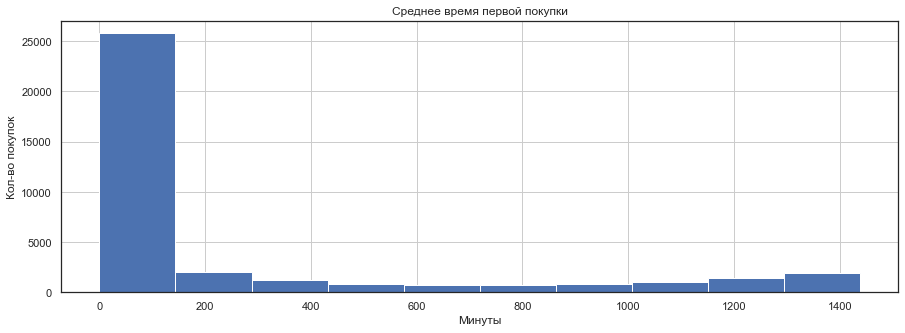

In [58]:
buying_time['buying_time'].hist()
plt.rcParams['figure.figsize']=(8,5)
plt.title('Среднее время первой покупки')
plt.xlabel('Минуты')
plt.ylabel('Кол-во покупок')
plt.show()

**Вывод:**   
большое количество покупок совершается в первый день. Далее количество покупок резко снижается и начинает немного отрастать на 1000 минуте. Предполагаю, что это пользователи, которые ожидали какого-то события и решили вернуться для покупки на Я.Афише.

### Cреднее количество покупок на одного покупателя

#### Когорта среднего количесва покупок на одного покупателя

In [59]:
# найдем число покупателей в каждой когорте
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders_per_month = orders.groupby('order_month').agg({'revenue': 'count'}).rename(columns={'revenue':'purchases'})
orders_per_month.reset_index()

,order_month,purchases
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


In [60]:
# добавим в информацию о покупках месяц первой покупки
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [61]:
# посчитаем количесво новых покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [62]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [63]:
# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 
# Сбросим индекс методом reset_index()
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'count'}).reset_index().rename(columns={'revenue':'order_count'})

cohorts.head()

,first_order_month,order_month,order_count
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [64]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,order_count
0,2017-06-01,2023,2017-06-01,2354
1,2017-06-01,2023,2017-07-01,177
2,2017-06-01,2023,2017-08-01,174
3,2017-06-01,2023,2017-09-01,226
4,2017-06-01,2023,2017-10-01,292


In [65]:
report['time'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['time'] = report['time'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,order_count,time
0,2017-06-01,2023,2017-06-01,2354,0
1,2017-06-01,2023,2017-07-01,177,1
2,2017-06-01,2023,2017-08-01,174,2
3,2017-06-01,2023,2017-09-01,226,3
4,2017-06-01,2023,2017-10-01,292,4


In [66]:
report['mean_order'] = report['order_count'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,order_count,time,mean_order
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2,0.049816
75,2018-04-01,2276,2018-04-01,2495,0,1.096221
76,2018-04-01,2276,2018-05-01,195,1,0.085677
77,2018-05-01,2988,2018-05-01,3249,0,1.087349


In [67]:
output_order_mean = report.pivot_table(
        index='first_order_month', 
        columns='time', 
        values='mean_order', 
        aggfunc='mean').round(2)
output_order_mean.index = output_order_mean.index.strftime("%m/%Y")
output_order_mean=output_order_mean.cumsum(axis=1).round(2)
# output_order_mean

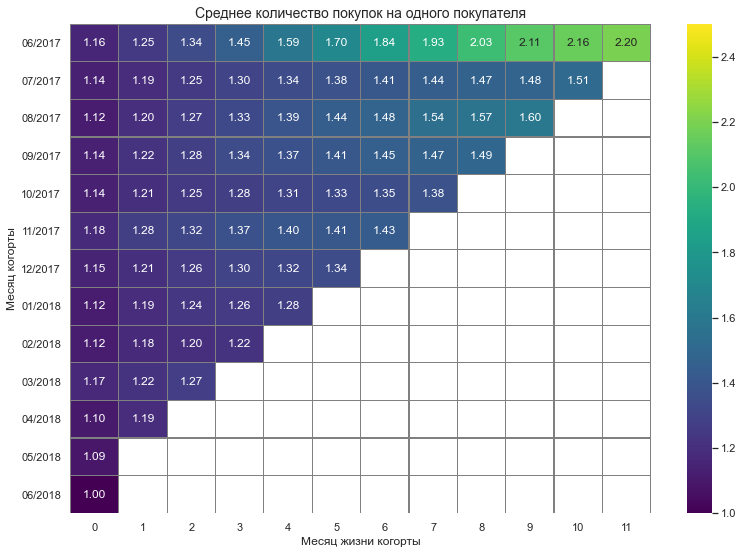

In [68]:
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок на одного покупателя', size=14)
ax=sns.heatmap(output_order_mean, annot=True, fmt='.2f', linewidths=0.2, linecolor='gray', vmin=1, vmax=2.5, cmap="viridis")
ax.set_ylabel('Месяц когорты')
ax.set_xlabel('Месяц жизни когорты')
plt.show()

#### Среднее количество покупкок в месяц

In [69]:
orders_mean = pd.merge(orders_per_month, cohort_sizes, left_on='order_month', right_on = 'first_order_month')

In [70]:
orders_mean['mean_orders'] = orders_mean['purchases'] / orders_mean['n_buyers']
f"В среднем в 1 месяц покупают - {round(orders_mean['mean_orders'].mean(),2)} раза"

'В среднем в 1 месяц покупают - 1.34 раза'

**Вывод:** 
Среднее количество покупок во всех когортах имеет рост. 
Наиболее успешные когорты по среднему количеству покупок: 06/2017, 07/2017, 08/2017, 11/2017.    
06/2017 - среднее кол-во покупок на 8 месяце жизни достигает 2. Возможно в этой когорте самые лояльные клиенты.    
---
В среднем в месяц покупают 1,34 раза.

### Средний чек

In [71]:
print('Средний чек равен:',round(orders['revenue'].mean()),'y.e')

Средний чек равен: 5 y.e


In [72]:
orders['revenue'].mode()

0    1.83
dtype: float64

In [73]:
orders

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01


In [74]:
mean_purchase_by_month = orders.groupby('order_month').agg({'revenue': 'mean'}).reset_index()
mean_purchase_by_month['order_month'] = mean_purchase_by_month['order_month']
mean_purchase_by_month

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280
5,2017-11-01,4.783518
6,2017-12-01,5.852139
7,2018-01-01,4.112927
8,2018-02-01,4.840095
9,2018-03-01,5.413930


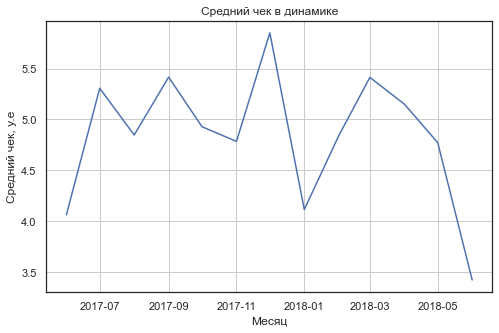

In [75]:
ax = sns.lineplot(x='order_month', y='revenue', data = mean_purchase_by_month)
plt.title('Средний чек в динамике')
plt.xlabel('Месяц')
plt.ylabel('Средний чек, y.e')
plt.grid()
plt.show()

**Вывод:**  
наиболее часто встречается стоимость 1.8 y.e.   
Средний чек = 5 y.e Средний чек резко вырастет в 12 месяце, а в 1 месяце снижается до показателей 7 месяца. Падение составляет около 43%.

### LTV
1. Найдём даты первой покупки;
2. Найдём число новых покупателей на каждую дату;
3. Добавим дату первой покупки в таблицу с заказами;
4. Сгруппируем таблицу и рассчитаем выручку

In [76]:
# месяц первой покупки для каждого клиента
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['buy_ts'] = pd.to_datetime(orders['order_month'], format = '%Y-%m-%d')
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [77]:
# Рассчитаем кол-во новых покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head(13)

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [78]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [79]:
# добавим месяц первой покукп в таблицу с заказами. Объединяем по uid клиента.
orders_new = pd.merge(orders, first_orders, on = 'uid')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01,0.37,14200605875248379450,2017-06-01,2017-06-01


In [80]:
# сгруппируем таблицу заказов по месяцу первой покупки и месяцу заказа, затем сложим выручку.
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [81]:
# добавим количество первых покупок в каждый месяц
final = pd.merge(cohorts,cohort_sizes, on = 'first_order_month')
final.head()

,first_order_month,order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


LTV рассчитывается из валовой прибыли, но так как у нас нет доступа к этим данным, будем считать что 100% выручка остаётся в компании.

In [82]:
final['time'] = (final['order_month'] - final['first_order_month']) / np.timedelta64(1, 'M')
final['time'] = final['time'].round().astype('int')

In [83]:
final.head()

,first_order_month,order_month,revenue,n_buyers,time
0,2017-06-01,2017-06-01,9557.49,2023,0
1,2017-06-01,2017-07-01,981.82,2023,1
2,2017-06-01,2017-08-01,885.34,2023,2
3,2017-06-01,2017-09-01,1931.30,2023,3
4,2017-06-01,2017-10-01,2068.58,2023,4


In [84]:
final['ltv'] = final['revenue']/final['n_buyers']
ltv_output = final.pivot_table(
        index='first_order_month', 
        columns='time', 
        values='ltv', 
        aggfunc='mean').round(2)
ltv_output.index = ltv_output.index.strftime("%m/%Y")
ltv_output= ltv_output.cumsum(axis=1).round(2)

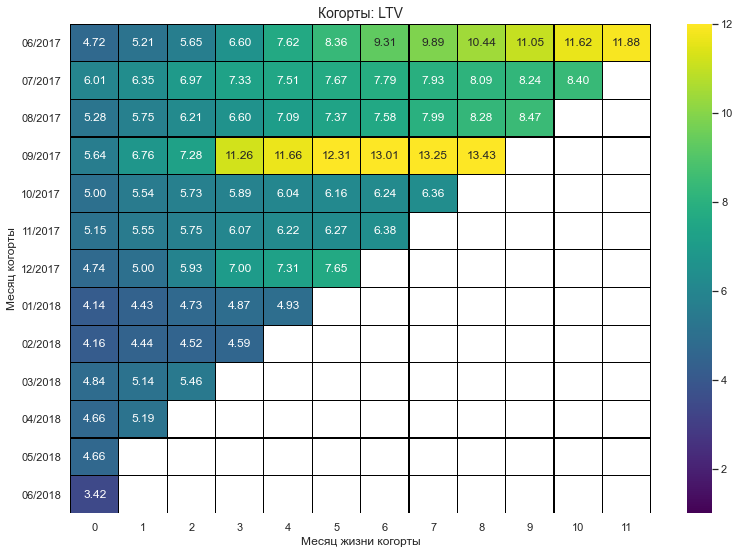

In [85]:
# визуализируем LTV
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: LTV', size=14)
ax=sns.heatmap(ltv_output, annot=True, fmt='.2f', linewidths=0.2, linecolor='black', vmin=1,  cmap="viridis", vmax=12)
ax.set_ylabel('Месяц когорты')
ax.set_xlabel('Месяц жизни когорты')
plt.show()

In [86]:
print('Cредний LTV по когортам за 6 месяцев:', ltv_output[6].mean())

Cредний LTV по когортам за 6 месяцев: 8.385


**Вывод:**  
 06/2017 и 09/2017 - являются самыми прибыльными когортами. В январе и феврале, на работу можно не выходить =)
 Очень сильный рост наблюдается в когортах 12/2017, 09/2017, 12/2017 на третьем месяце жизни. 
 Пожизненная стоимость клиента растёт по каждой кагорте, а значит есть потенциал для роста в каждой из них.

## Маркетинговые метрики

#### Сумма расходов

In [87]:
print('Сумма маркетинговых расходов:', costs['costs'].sum(), 'y.e')

Сумма маркетинговых расходов: 329131.62 y.e


#### Расходы по источникам

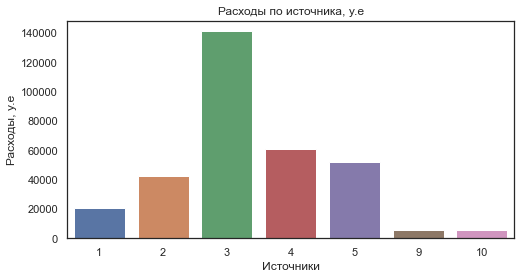

In [88]:
source_costs = costs.groupby(['source_id']).agg({'costs':'sum'}).reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='source_id', y='costs', data = source_costs)
plt.title('Расходы по источника, y.e')
plt.xlabel('Источники')
plt.ylabel('Расходы, y.e')
plt.show()

**Вывод:**  
максимальная сумма расходов приходится на источник №3.

#### Расходы по месяцам

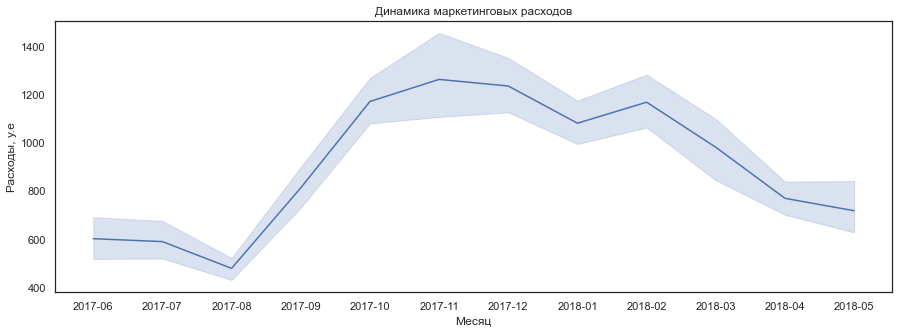

In [89]:
# производили данные расчёты в разделе DAU, WAU, MAU
plt.rcParams['figure.figsize']=(15,5)
cost_mrkt = costs.groupby(['dt']).agg({'costs':'sum'}).reset_index()
cost_mrkt['dt']=cost_mrkt['dt'].dt.strftime('%Y-%m')
sns.lineplot(x = 'dt' , y = 'costs', data = cost_mrkt)
plt.title('Динамика маркетинговых расходов')
plt.xlabel('Месяц')
plt.ylabel('Расходы, у.е')
plt.show()

In [90]:
monthly_costs=cost_mrkt.groupby('dt').agg({'costs':'sum'}).reset_index()
monthly_costs['dt'] = monthly_costs['dt'].astype('datetime64[M]')
monthly_costs_mean = monthly_costs.mean().round()
print('Среднемесячные траты:', monthly_costs_mean)

Среднемесячные траты: costs    27428.0
dtype: float64


<ipython-input-90-e1387c992dd1>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  monthly_costs_mean = monthly_costs.mean().round()


**Вывод:**  
больше всего маркетинговых расходов приходится на 10, 11 и 12 месяцы. В среднем расходуется около 27 428 y.e

### CAC

#### CAC по всему проекту

In [91]:
# день первого визита и его рекламный источник
first_visit_day = visits.groupby(['uid','source_id']).agg({'start_ts':'min'}).reset_index()
first_visit_day.columns = 'uid','source_id','start_ts'
first_visit_day.head()

,uid,source_id,start_ts
0,11863502262781,3,2018-03-01 17:27:00
1,49537067089222,2,2018-02-06 15:55:00
2,297729379853735,3,2017-06-07 18:47:00
3,313578113262317,2,2017-09-18 22:49:00
4,325320750514679,5,2017-09-30 14:29:00


In [92]:
# # Маркетинговые расходы по месяцам
monthly_costs.columns = 'month', 'costs'
monthly_costs

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [93]:
report_cac = pd.merge(report, 
                      monthly_costs, 
                      left_on = 'first_order_month',
                      right_on = 'month')
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers']
report_cac.head()

,first_order_month,n_buyers,order_month,order_count,time,mean_order,month,costs,cac
0,2017-06-01,2023,2017-06-01,2354,0,1.163618,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,177,1,0.087494,2017-06-01,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,174,2,0.086011,2017-06-01,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,226,3,0.111715,2017-06-01,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,292,4,0.144340,2017-06-01,18015.0,8.905091


In [94]:
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers']
report_cac['month'] = report_cac['month'].dt.strftime('%Y-%m')
report_cac.head()

,first_order_month,n_buyers,order_month,order_count,time,mean_order,month,costs,cac
0,2017-06-01,2023,2017-06-01,2354,0,1.163618,2017-06,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,177,1,0.087494,2017-06,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,174,2,0.086011,2017-06,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,226,3,0.111715,2017-06,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,292,4,0.144340,2017-06,18015.0,8.905091


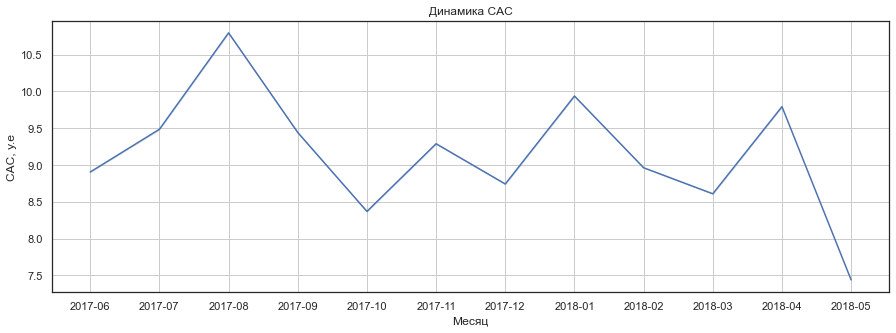

In [95]:
# график динамики CAC
sns.lineplot(x = 'month' , y = 'cac', data = report_cac)
plt.rcParams['figure.figsize']=(15,5)
plt.title('Динамика CAC')
plt.xlabel('Месяц')
plt.ylabel('CAC, у.е')
plt.grid()
plt.show()

**Вывод:**  
самоё дорогое привлечение приходится на 2017-08 и составляет 9.7 y.e, затем в 2017-09 и 2017-08 CAC резко снижается до 8.4 y.e. Далее растёт до 10 y.e, пик данного роста приходится на 2017-12, затем снижается до рекодно низких значений в 7.5 y.e, на дату 2018-05.    
Возможная причина роста на 2017-08, это запуск новых рекламных кампаний на новом(ых) источнике(ах).  

#### Средний CAC по сему проекту

In [96]:
# Средний CAC по сему проекту
cac_mean  = report_cac['cac'].mean()
print(f'Средний CAC по всему проекту =  {cac_mean:.2f} y.e')

Средний CAC по всему проекту =  9.32 y.e


#### CAC по источникам

In [97]:
visits_by_source = visits.sort_values('start_ts').groupby('uid').first()
visits_by_source = visits_by_source['source_id']
orders_by_source = orders.merge(visits_by_source, on = 'uid', how = 'left')
orders_by_source.head()

,buy_ts,revenue,uid,order_month,source_id
0,2017-06-01,17.00,10329302124590727494,2017-06-01,1
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2
2,2017-06-01,0.37,17903680561304213844,2017-06-01,2
3,2017-06-01,0.55,16109239769442553005,2017-06-01,2
4,2017-06-01,0.37,14200605875248379450,2017-06-01,3


In [98]:
orders_by_source['order_month'] = orders_by_source['order_month'].astype('datetime64[D]')
cac_per_source_id = (orders_by_source.groupby(['source_id'], as_index = False)
                     .agg({'uid':'nunique'})
                     .rename(columns = {'uid':'n_buyers'})
                     .merge(costs.groupby('source_id', as_index = False)
                            .agg({'costs': 'sum'}), on = 'source_id')
                     .assign(cac = lambda row: row['costs'] / row['n_buyers'])
                    )
cac_per_source_id

,source_id,n_buyers,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


**Вывод:**   
самое дорогое привлечение приходится на источник №3. Стоимость привлечения одного клиента = 13.49 y.e Данный канал также привлёк 10473 клиентов. Так как это самый дорогой канал, можно отказаться от данного канала и распределить его бюджет на более привлекательные.

  
 
Над каналом 9 и 10 явно необходимо ещё поэксперементировать, так как стоимость клиента низкая, а бюджет израсходаван в разы ниже, по сравнению с другими источниками.

### ROMI

In [99]:
romi=pd.merge(final, monthly_costs, left_on='first_order_month', right_on='month')
romi['cac'] = romi['costs'] / romi['n_buyers']
romi['romi'] = romi['ltv'] / romi['cac']
output = romi.pivot_table(
        index='first_order_month', 
        columns='time', 
        values='romi', 
        aggfunc='mean')

output=output.cumsum(axis=1).round(2)
output.index = output.index.strftime("%m/%Y")

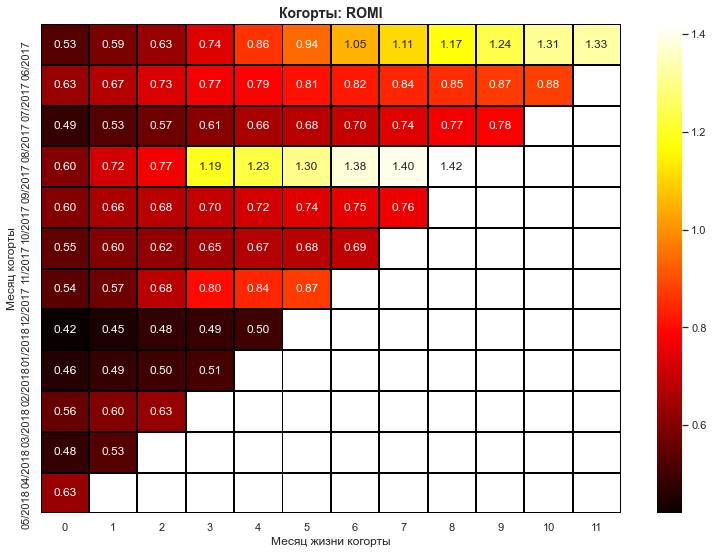

In [100]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: ROMI', size=14, weight = 'bold')
ax=sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap = 'hot')
ax.set_ylabel('Месяц когорты')
ax.set_xlabel('Месяц жизни когорты');

**Вывод:**  
окупились когорты:    
- 06/2017 на 6 месяце
- 09/2017 на 3 месяце.

### Рассчитаем ROMI по источникам рекламы

In [101]:
# найдем рекламный источник первого визита для каждого клиента
# и объеденим с таблицей orders

first_uid_source = visits.groupby(['uid'])['source_id'].min()
first_uid_source.name = 'first_uid_source'
first_uid_source = orders.join(first_uid_source,on='uid')
first_uid_source.head()

,buy_ts,revenue,uid,order_month,first_uid_source
0,2017-06-01,17.00,10329302124590727494,2017-06-01,1
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2
2,2017-06-01,0.37,17903680561304213844,2017-06-01,2
3,2017-06-01,0.55,16109239769442553005,2017-06-01,2
4,2017-06-01,0.37,14200605875248379450,2017-06-01,3


In [102]:
# выведем выручку по каждому источнику
revenue_source=first_uid_source.groupby(['first_uid_source'])['revenue'].sum().reset_index()
revenue_source

,first_uid_source,revenue
0,1,101631.38
1,2,43123.74
2,3,43354.82
3,4,36705.84
4,5,22919.80
5,7,1.22
6,9,1874.18
7,10,2446.22


In [103]:
romi_source = cac_per_source_id.merge(revenue_source, left_on='source_id', right_on='first_uid_source')
romi_source['romi']=romi_source['revenue']/romi_source['costs']
romi_source.drop('first_uid_source', axis=1, inplace=True)

romi_source

,source_id,n_buyers,costs,cac,revenue,romi
0,1,2899,20833.27,7.186364,101631.38,4.878321
1,2,3506,42806.04,12.209367,43123.74,1.007422
2,3,10473,141321.63,13.493901,43354.82,0.306781
3,4,10296,61073.60,5.931779,36705.84,0.601010
4,5,6931,51757.10,7.467479,22919.80,0.442834
5,9,1088,5517.49,5.071222,1874.18,0.339680
6,10,1329,5822.49,4.381106,2446.22,0.420133


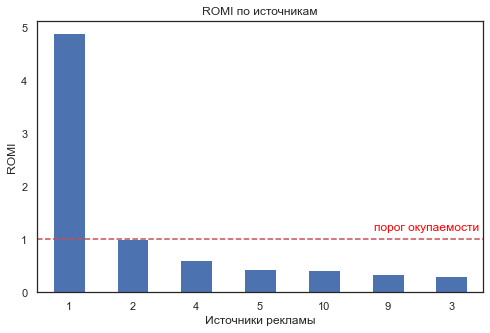

In [104]:
output = romi_source.sort_values(by='romi', ascending=False).reset_index()

ax=output.plot(y='romi', x='source_id', kind='bar', figsize=(8, 5), title='ROMI по источникам', legend=False, rot=360)
plt.axhline(y=1, color='r', linestyle='--')
ax.text(.99, 0.22, 'порог окупаемости',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='red', fontsize=12)
plt.xlabel('Источники рекламы')
plt.ylabel('ROMI')
plt.show()

**Вывод:**  
источник №1 окупается почти в 4 раза. Источник 2 выходит в ноль, при том, он самый дорогой. 
Остальные источники с первого взгляда не являются прибыльными, но это совсем не так. Если сложить ROMI данных источников, то данные каналы имеют право на жизнь.

# Общий вывод

## Выполненные работы     

    1. Данные изучены и подготовлены к анализу     
    2. Рассчитаны метрики     
    3. Построены необходимые графики  

**Рассчитал и отобразил:**

Продукт:
- Посещаемость DAU, WAU, MAU
- Количество сессий и их продолжительность
- Retantion rate

E-commerce:
- Время совершения первой покупки
- Среднее количество покупок за 6 месяцев
- Средний чек
- LTV

Маркетинг:
- Сумма расходов
- Расходы по источникам
- Расходы по месяцам
- CAC
- ROMI

## Итоговый вывод

Яндекс.Афиша с июня 2017 по конец мая 2018 года    
Всего посещений за: 359400     
Всего покупок: 50415     
Конверсия в покупку = 14%     
Business season начинается в марте и завершается в сентябре.     
Бизнесу свойственны событийные транзакции.
Если включить в рассчёты аренду офиса, пресонал и др. постоянные расходы, то бизнес сильно работает в минус.
- - -
Ежeдневная аудитория DAU: 908 человек;     
Еженедельная аудитория WAU: 5825 человек;     
Ежемесячная аудитория WAU: 23228 человек;    
Среднее количество сессий в день: 987 сессий;    
В среднем сессия длится: 11 минут;    
Когорта 06/2017 имеет самый высокий Retention Rate на протяжении всего периода;     
Заказ совершается в первые 150 минут;     
В среднем покупают в день/неделя/месяц, раз: 138.502 / 969.519 / 4201.250;     
Средний чек составляет: 5 y.e;     
Больше всего маркетинговых расходов приходится на 10, 11 и 12 месяцы. В среднем расходуется около 27 428 y.e     
окупились когорты:    
- 06/2017 на 6 месяце
- 09/2017 на 3 месяце.    

Средний CAC 9.32 y.e больше среднего чека 5 y.e, что сигнализирует о проблемах.     


ROMI: источник №1 окупается почти в 4 раза. Источник 2 выходит в ноль, при том он самый дорогой. 
Остальные источники с первого взгляда не являются прибыльными, но это совсем не так. Если сложить ROMI данных истоников, то данные каналы имеют право на жизнь.

**Предложение по маркетинговой стратегии**    
Из всех маркетинговых стратегий, самая удачная была в сентябре 2017 г. её можно взять за ориентир или вернуться к её более подробному изучению. 


Если канал №1 является email рассылка по своей базе, то все же не стоит рассматривать данный канал как привлечение новых пользователей, он будет лучше работать на удержание. Бизнес нужно масштабировать привлекая новых клиентов. А для этого нужно тестировать новые каналы привлечения, отказываясь от неэффективных.    
Поэтому шаги должны быть такие:
1. Определить max CAC, который нельзя превышать. Глобально CAC не должен превышать средний чек = 5 y.e.
2. Отказаться от канала №3 и перекинуть его бюджет на дургие, более привлекательные каналы.
3. Заняться поиском, ранее неиспользуемых каналов привлечения.